### Подготовительный этап.

In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from random import random
import csv
import json # пока писать будет в json, но если что переделаем

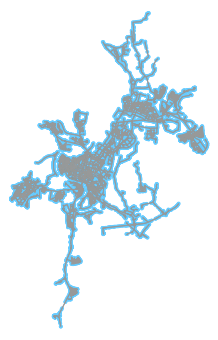

In [3]:
place = {'city' : 'Ufa',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive', simplify=False)

fig, ax = ox.plot_graph(G)

In [4]:
# нахождение расстояний между смежными узлами
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})                  

In [5]:
nodes_list = list(G.nodes())

In [6]:
# вытаскиваем больницы и дома
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)


hospital = []
apartments = []
n = 10000
build = buildings.head(n)['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospital.append(key)
    elif value == 'apartments':
        apartments.append(key)

hospitals = hospital[:10]
apartments = apartments[:100]

# print(hospitals)
# print(apartments)

In [7]:
# для каждой больницы и дома находим соответсвующие им (ближайшие) ноды на графе
a = buildings.head(n).to_dict()
hospitals_dict = {}
apartments_dict = {}

for i in hospitals:   
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node
    # print(i, nearest_node)

for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node
    # print(i, nearest_node)

In [ ]:
# пример визуализации кратчайших путей (точки взяты из предыдущего пункта)
route = nx.shortest_path(G,
                         892683760,
                         498826321, 
                         weight='length') 

ox.plot_graph_route(G, route, fig_height=10, fig_width=10)

In [8]:
# матрица смежностти в пандас
G_pd = nx.to_pandas_adjacency(G)

# можно записать в эксель и это даже работает!!
# G_pd.to_csv('matrix_adjacency_pandas.csv')

In [9]:
# переводив в нампаевский ndarray
# !запускать только один раз!
G_pd = G_pd.values

In [10]:
print(G_pd)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
# пишем полученный ndarray в csv
with open('matrix_adjacency.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in G_pd:
        writer.writerow(line)

KeyboardInterrupt: 

In [12]:
# вместо нулей и единиц записываем в матрицу смежности расстояния между нодами (по формуле из файла)
for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1
            G_pd[i][j] = distance * weight
# если ребра между нодами нет, то заполняем большими расстояниями (для нахождения крастчайших путей)
# возможно, можно придумать что-то менее костыльное
        if G_pd[i][j] == 0:
            G_pd[i][j] = 10**10

In [13]:
# Создаем словарь {id узла}: {его index в списке узлов}
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 

In [14]:
# алгоритм Дейкстры поиска кратчайших путей
# pred - матрица с предками
# взят отсюда https://ru.wikibooks.org/wiki/Реализации_алгоритмов/Алгоритм_Дейкстры
def dijkstra(N, S, matrix, pred):
    valid = [True]*N
    weight = [10**10]*N
    weight[S] = 0
    for i in range(N):
        min_weight = 10**10+1
        ID_min_weight = -1
        for j in range(N):
            if valid[j] and weight[j] < min_weight:
                min_weight = weight[j]
                ID_min_weight = j
        for z in range(N):
            if weight[ID_min_weight] + matrix[ID_min_weight][z] < weight[z]:
                weight[z] = weight[ID_min_weight] + matrix[ID_min_weight][z]
                pred[z] = ID_min_weight
        valid[ID_min_weight] = False
    return weight

In [15]:
# делаем листы для использования Дейсктры 
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())

In [16]:
# создаем общий лист, чтобы сделать и дома, и больницы одновременно
new_nodes = apartments_values + hospital_values

In [17]:
# матрица в которой будем хранить значения кратчайших путей
short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))

# словарь, который хранит дерево кратчайших расстояний из вершины i
pred_dict = {}

index_nodes = [] # индексы узлов домов
for i in new_nodes:
    index_nodes.append(nodes_numbers[i]) # в качестве индекса номер, соответствующий id узла

In [19]:
# пример работы дейкстры, работает около 30-40 минут (хз почеу)
import time
start = time.time()
p = {}
dijkstra(len(G_pd), 0, G_pd, p)
# вывод дерева кратчайших путей из вершины 0, где у каждого узла указан предок
print(p)
print(time.time() - start)

{52: 0, 363: 0, 106: 52, 89: 106, 21190: 89, 3500: 363, 21567: 363, 176: 21190, 21384: 21190, 25551: 3500, 21466: 176, 21013: 21567, 21073: 21567, 6813: 25551, 3635: 21466, 21501: 21466, 21030: 21384, 21207: 21384, 21538: 21073, 23589: 21013, 21585: 21030, 312: 6813, 21637: 3635, 8242: 23589, 4151: 8242, 4153: 8242, 20104: 8242, 21048: 21207, 4148: 20104, 8455: 312, 13829: 312, 13822: 8455, 21052: 21637, 21180: 21637, 21158: 4151, 8578: 13829, 13787: 13829, 13751: 13787, 20970: 21501, 8613: 21585, 4155: 4153, 8354: 21501, 21351: 21158, 4160: 8613, 8320: 8613, 21100: 8613, 20214: 4148, 21520: 21351, 13797: 13751, 8414: 4155, 4158: 8414, 20096: 21520, 8271: 13822, 13776: 13822, 21382: 21180, 20995: 21100, 21531: 21382, 20982: 20995, 13760: 13797, 8282: 8271, 287: 8354, 4171: 8354, 4172: 8354, 13807: 8578, 20030: 20096, 22063: 20096, 8510: 21531, 4170: 4171, 4173: 4172, 4163: 8320, 22477: 20030, 13825: 13807, 20239: 13807, 13756: 13760, 13852: 13760, 4169: 4170, 4168: 4169, 13834: 13756, 

In [ ]:
# поиск кратчайших путей (по расстоянию, если что (а то там был варик по времени поездки))
for i in range(len(new_nodes)):
    pred = {}
    index = index_nodes[i]
    distance = dijkstra(len(G_pd), index, G_pd, pred)
    pred_dict[index] = pred
    for j in range(len(new_nodes)):
        short_path_matrix[i][j] = distance[index_nodes[j]]

        
print(short_path_matrix)

In [ ]:
# если нет кратчайшего пути, то ставим очень большое число
for i in range(len(new_nodes)):
    for j in range(len(new_nodes)):
        if short_path_matrix[i][j] == 0 and i!=j:
            short_path_matrix[i][j] = 10**10

In [ ]:
b = short_path_matrix.tolist()
a = {'matrix':b}

# пишем в json матрицу кратчайших путей
with open('short_path.json','w') as f:
    json.dump(a,f)

In [ ]:
# записываем матрицу кратчайших путей в csv
with open('matrix_adjacency_final.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in short_path_matrix:
        writer.writerow(line)

In [ ]:
# функция, находящая кратчайший путь между двумя вершинами a и b 
def find_short_path(pred_dict, index_a, index_b):
    path = []
    path.append(index_b)
    temp = index_b
    while pred_dict[index_a][temp] != index_a:
        path.append(pred_dict[index_a][temp])
        temp = pred_dict[index_a][temp]
    path.append(index_a)
    path.reverse()
    return path

In [ ]:
# пишем в json файл дерево кратчайших путей
with open('short_path_tree.json', 'w') as f:
    json.dump(pred_dict, f)

In [ ]:
# то же самое, что предыдущее, но для всех путей
def find_all_short_path(pred_dict):
    short_paths = {}
    for i in pred_dict.keys():
        path = {}
        for j in pred_dict[i].keys():
            path[j] = find_short_path(pred_dict, i, j)
        short_paths[i] = path
    return short_paths

short_paths = find_all_short_path(pred_dict)

In [ ]:
# пишем в json все кратчайшие пути
with open('short_paths.json', 'w') as f:
    json.dump(short_paths, f)

In [ ]:
# получение ключа 
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
    return -1

# получение айди
def get_id(nodes_numbers, index_nodes, i):
    temp = get_key(nodes_numbers, index_nodes[i])
    if temp == -1:
        return "Не найдено id узла"
    else:
        return temp

### Первое задание (пункты подписаны).

In [ ]:
from numpy import genfromtxt
# считываем матрицу кратчайгих расстояний из csv файла
data = genfromtxt('matrix_adjacency_final.csv', delimiter=',') 

### Пункт 1.а 
Для каждого дома определить ближайший от узла объект (путь “туда”), ближайший к объекту узел (путь “обратно”), объект, расстояние до которого и обратно минимально (“туда и обратно”).

In [ ]:
# функция нахождения ближайшей больницы
def find_nearest_hospitals(dist_matrix, apart_count=100):
    nearest_hosp_list = [[-1 for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        nearest_hosp_list[i][0] = np.argmin(dist_matrix[i][apart_count:]) + apart_count
        nearest_hosp_list[i][1] = np.argmin(np.array(dist_matrix[apart_count:]).transpose()[i]) + apart_count
        tuda = dist_matrix[i][apart_count:]
        suda = np.array(dist_matrix[apart_count:]).transpose()[i]
        nearest_hosp_list[i][2] = np.argmin(tuda + suda) + apart_count
    return nearest_hosp_list

In [ ]:
# запуск программы
find_nearest_hospitals(data)

### Пункт 1.b
Для каждого дома определить объекты, расположенные не далее, чем в X км для каждого из трех вариантов “туда”, “обратно”, “туда и обратно”.

In [ ]:
# возвращаемый список содержит списки с 3-мя списками индексов подходящих объектов: "туда", "обратно" и "туда и обратно" 
# содержат своё количество индексов - это списки второго уровня,индекс списка первого уровня соответствует индексу дома во входной матрице расстояний. 
def find_in_radius(dist_matrix, radius, apart_count=100):
    permissible_hosps = [[[] for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        for j in range(apart_count, len(dist_matrix)):
            if dist_matrix[i][j] <= radius:
                permissible_hosps[i][0].append(j)
            if dist_matrix[j][i] <= radius:
                permissible_hosps[i][1].append(j)
            if dist_matrix[i][j] + dist_matrix[j][i] <= radius:
                permissible_hosps[i][2].append(j)
    return permissible_hosps

In [ ]:
# запуск программы, radius произвольный
radius = 500
find_in_radius(data, radius)

### Пункт 2
Определить, какой из объектов расположен так, что расстояние между ним и самым дальним домом минимально (“туда”, “обратно”, “туда и обратно”).

In [ ]:
# возвращаемый список содержит три больницы - [ "туда", "обратно", "туда и обратно" ], где "туда" – из дома в больницу
def get_optimal_hospitals(dist_matrix, apart_count=100):
    optimal_hosps = []
    tuda = np.array(dist_matrix[:apart_count]).transpose()[apart_count:]
    optimal_hosps.append(np.argmin(np.amax(tuda, 1)) + apart_count)
    suda = np.array(dist_matrix[apart_count:])[:, :apart_count]
    optimal_hosps.append(np.argmin(np.amax(suda, 1)) + apart_count)
    tuda_suda = tuda + suda
    optimal_hosps.append(np.argmin(np.amax(tuda_suda, 1)) + apart_count)
    return optimal_hosps

In [ ]:
# запуск программы
opt = get_optimal_hospitals(data)

### Пункт 3

Определить, для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна.

In [ ]:
# возвращает id больницы
def min_sum_hosp(dist_matrix, apart_count=100):
    dist_sums = np.array(dist_matrix[apart_count:])[:, :apart_count]
    dist_sums = np.sum(dist_sums, 1)
    min_hosp = np.argmin(dist_sums) + apart_count
    hosp_id = get_id(nodes_numbers, index_nodes, min_hosp)
    return hosp_id

In [ ]:
# запуск программы
min_hosp_id = min_sum_hosp(data)

### Пункт 4
Определить, для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.

In [ ]:
# считаем вес дерева кратчаших путей
def tree_weight(tree, root, matrix):
    weight = 0
    for i in tree[root].keys():
        j = tree[root][i]
        weight += matrix[j][i]
    return weight

# нахождение дерева минимального веса, где корни - больницы
def minimal_tree_hospitals(tree, matrix, hospitals):
    min_value = 10**10
    root = 0
    for i in hospitals:
        temp = tree_weight(tree, str(i), matrix)
        print(i, temp)
        if temp < min_value:
            min_value = temp
            root = i
    return root

In [ ]:
# загружаем наши деревья кратчайших путей
with open('short_path_tree.json') as f:
    short_path_tree = json.load(f)

# берем список деревьев (они в конце index_nodes, поэтому берем последние 10)
hospitals = index_nodes[:-10]

# ищем номер корня дерева минимального веса из больниц
min_tree_root = minimal_tree_hospitals(short_path_tree, data, hospitals)
hosp_id = get_id(nodes_numbers, index_nodes, min_tree_root)